In [56]:
#import Pkg; 
#using Pkg;

#Pkg.add("ColorSchemes")
using Distributions, ColorSchemes, Statistics
  
# to create dataframes and load
#Pkg.add("DataFrames")
using DataFrames
  
# to use the above function kmeans()
#Pkg.add("Clustering")
using Clustering
  
# RDatasets to load the already made datasets
#Pkg.add("RDatasets")
using RDatasets

#Pkg.add("GR")
#Pkg.build("GR")
#import Pkg; Pkg.add("Plots")

using Plots, GeometryBasics, VoronoiCells
default(size=(800,600))

In [57]:
function rbf(x; weights=[1], centers=[0,0], sigma2=[1])
    
    @assert length(weights)==size(centers)[1]==length(sigma2)>0 #chequeo consistencia de n>0
    K=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x[1])
    
    kernels = [exp(-(x-centers[j])'*(x-centers[j])/sigma2[j]) for j=1:K]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

In [58]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = Point2(u1,u2)
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

In [59]:
function integrate_voronoi(f, total_area, total_points)
    return total_area/total_points*sum(f)
end

function g(x;w,mu,sigma2)
   return rbf(x, weights=w, centers=mu, sigma2=sigma2)
end

function h(x;w,mu,sigma2)
    return 1
end

function g_j(x;j,w,mu,sigma2)
   return rbf(x, weights=[w[j]], centers=[mu[j]], sigma2=[sigma2[j]])
end

function h0_j(x;j,w,mu,sigma2)
    return 1/w[j]
end

function h1_j(x;j,w,mu,sigma2)
    return (x-mu[j])'*(x-mu[j])/(sigma2[j]^4)
end

function h2_j(x;j,w,mu,sigma2)
    return  -2/sigma2[j]^2*(x-mu[j])
end

h2_j (generic function with 1 method)

In [60]:
function calculate_w(v_i, y, mu, sigma2, A_X, P)
    s = length(y)
    K = length(mu)
    
    # Calculate A matrix
    A = zeros(s,K)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            g_j_aux = g_j.(v, j=j, w=ones(1,K), mu=mu, sigma2=sigma2)
            A[i,j] =  integrate_voronoi(g_j_aux, A_X, P)
        end
    end
    
    # Least square min||Aw-y||
    w = (A \ y)
end

calculate_w (generic function with 1 method)

In [61]:
function integrate(x, v_i, theta, error_i)
    
    w = theta[1]
    mu = theta[2]
    sigma2 = theta[3]
    
    K = length(w)
    s = length(error_i)
    
    # ========== Compute Loss differentials aproximations ========== 
    #n0 = zeros(s,K)
    n1 = zeros(s,K)
    n2x1 = zeros(s,K)
    n2x2 = zeros(s,K)

    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        for j=1:K
            
            g_j_out  = g_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            
            # Para w_j (ahora por minimos cuadrados)
            #h0_j_out = h0_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            #n0[i,j] = (integrate_voronoi(g_j_out.*h0_j_out, A_X, P))
            
            # Para sigma2_j
            h1_j_out = h1_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n1[i,j] = (integrate_voronoi(g_j_out.*h1_j_out, A_X, P))
            
            # Para mu_j (se separa por cada dimension)
            h2_j_out = h2_j.(v, j=j, w=w, mu=mu, sigma2=sigma2)
            n2x1[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][1] for l = 1:length(h2_j_out)], A_X, P))
            n2x2[i,j] = (integrate_voronoi(g_j_out.*[h2_j_out[l][2] for l = 1:length(h2_j_out)], A_X, P))
        end
    end
    
    # ========== Make the sums ========== 
    dL_w = zeros(K)
    dL_sigma2 = zeros(K)
    dL_mux1 = zeros(K)
    dL_mux2 = zeros(K)

    for j = 1:K
        #dL_w[j] = sum(error_i.*n0_ij[:,j])
        dL_sigma2[j] = sum(error_i.*n1[:,j])
        dL_mux1[j] = sum(error_i.*n2x1[:,j])
        dL_mux2[j] = sum(error_i.*n2x2[:,j])
    end

    dL_mu = [[dL_mux1[j], dL_mux2[j]] for j = 1:K] 

    dL = dL_w, dL_mu, dL_sigma2
    return dL
end

integrate (generic function with 1 method)

# Validar funciones

## Idea:
1. Generar una RBF de dos centros con parámetros conocidos
2. Indicar 4 sitios y asignar la demanda según la RBF (trabajar con simetrías para facilitar)
3. Reconstruir la RBF original a partir de los datos

In [158]:
import Random
Random.seed!(100)

X1_min = -1;
X1_max = 1;
Delta_X1 = X1_max - X1_min
X2_min = -1;
X2_max = 1;
Delta_X2 = X2_max - X2_min
A_X = Delta_X1*Delta_X2;
P = 1000*round(A_X); #Cantidad de puntos a sortear (1000 por unidad de área)

nu_min = 0.005;
nu_max = 0.01;
nu_decay = 0.99;
integration_max_steps = 25000;
integration_max_error = 0.0001;

s = 4 # Count of sites 
d = 2 # Space Dimension

#x = sortslices(rand(Uniform(0,1),s,d), dims = 1) # Sites coordinates in R^d
x = [0.75 0.80; 0.25 0.80; 0.25 0.20; 0.75 0.20];
x1 = x[:,1] = x[:,1].*Delta_X1.+X1_min
x2 = x[:,2] = x[:,2].*Delta_X2.+X2_min

X = sortslices(rand(Uniform(0,1),P,d), dims = 1); # Auxiliar points to integrate
X1 = X[:,1] = X[:,1].*Delta_X1.+X1_min
X2 = X[:,2] = X[:,2].*Delta_X2.+X2_min

K = 2; # Count of kernels

# Voronoi assigments
norm = 2
W = [(sum((x[i,:]-X[k,:]).^norm))^(1/norm) for i=1:s,k=1:P];
attachs = zeros(P)
for k=1:P    
    _,idx = findmin(W[:,k])
    attachs[k] = idx
end
attachs = Int64.(attachs);
v_i = [ X[findall(x->x==i,attachs),:] for i in 1:s ]; 

### 1. Generar RBF de dos centros con parámetros conocidos

In [159]:
w_ini = [1/(2*pi), 1/(2*pi)];
mu_ini = [[-0.5, -0.5], [0.5, 0.5]];
sigma2_ini = [1/2, 1/2];
println("mu_ini= ", mu_ini)
println("sigma2_ini= ", sigma2_ini)
println("w_ini= ", w_ini)

x1_rbf=(X1_min:0.05:X1_max);
x2_rbf=(X2_min:0.05:X2_max);
x_rbf=[[a, b] for b in x2_rbf, a in x1_rbf]; ##el orden de b y a importa no entendí por qué.
z = rbf.(x_rbf, weights=w_ini, centers=mu_ini, sigma2=sigma2_ini);
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)

x_aux = Point2{Float64}[]
for i=1:s
    aux = Point2(x1[i],x2[i])
    push!(x_aux,aux)
end
rect = Rectangle(Point2(X1_min, X2_min), Point2(X1_max, X2_max));
tess = voronoicells(x_aux, rect);

mu_ini= [[-0.5, -0.5], [0.5, 0.5]]
sigma2_ini= [0.5, 0.5]
w_ini= [0.15915494309189535, 0.15915494309189535]


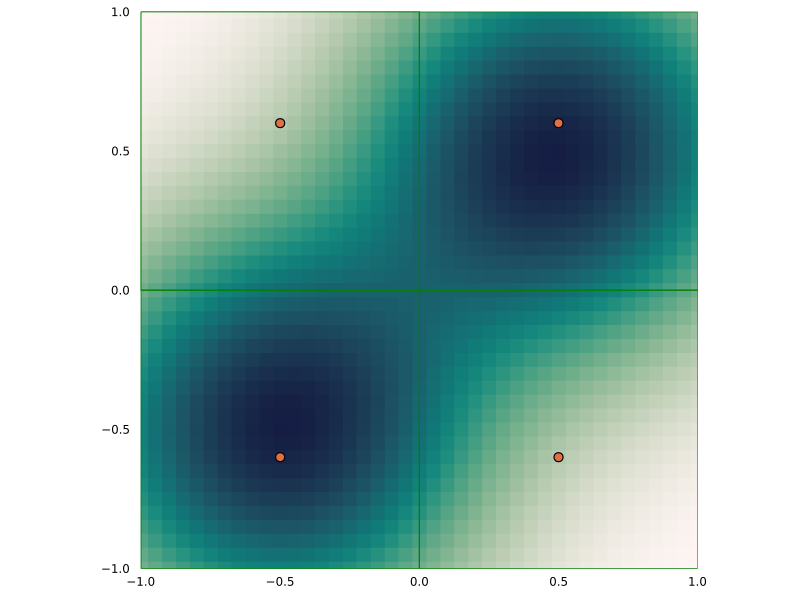

In [160]:
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

#annotate!([(x1[i] + 0.02, x2[i] + 0.03, text(i, :black)) for i in 1:s]) # Add Station Number

plot!(tess, alpha=1, color=:green)

### 2. Indicar 4 sitios y asignar la demanda según la RBF

In [161]:
# Calcular la demanda por sitio (asignaciones)
y = zeros(s)
for i = 1:s   
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    # For each station -> Integrates the RBF 
    g_out = g.(v, w=w_ini, mu=mu_ini, sigma2=sigma2_ini)
    y[i] = integrate_voronoi(g_out, A_X, P)
end
println("y = ", y)

y = [0.1189439618209393, 0.05020586457561784, 0.13092782520914192, 0.05409450915534222]


### 3. Reconstruir la RBF original

#### Inicialización

In [162]:
# THETA INITIALIZATION 
R = kmeans(x', K, weights = y, maxiter = 200, display=:iter);
println("========")
mu = [[R.centers'[j,1],R.centers'[j,2]] for j=1:K];
println("mu= ", mu)
mu1 = R.centers'[:,1];
mu2 = R.centers'[:,2];

sigma2 = [var(x[findall(x->x==j,assignments(R)),:]) for j in 1:K];
println("sigma2= ", sigma2)

w = calculate_w(v_i, y, mu, sigma2, A_X, P);
println("w= ", w)

theta0 = w, mu, sigma2;
theta = theta0;

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.498718e-01
      1       7.358315e-02      -1.762886e-01 |        0
      2       7.358315e-02       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 0.07358314728171998)
mu= [[-0.2076325442485288, -0.5999999999999999], [0.20318701682900617, 0.6000000000000001]]
sigma2= [0.2866666666666667, 0.2866666666666668]
w= [0.23121710359926378, 0.23959484197207429]


In [163]:
z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);

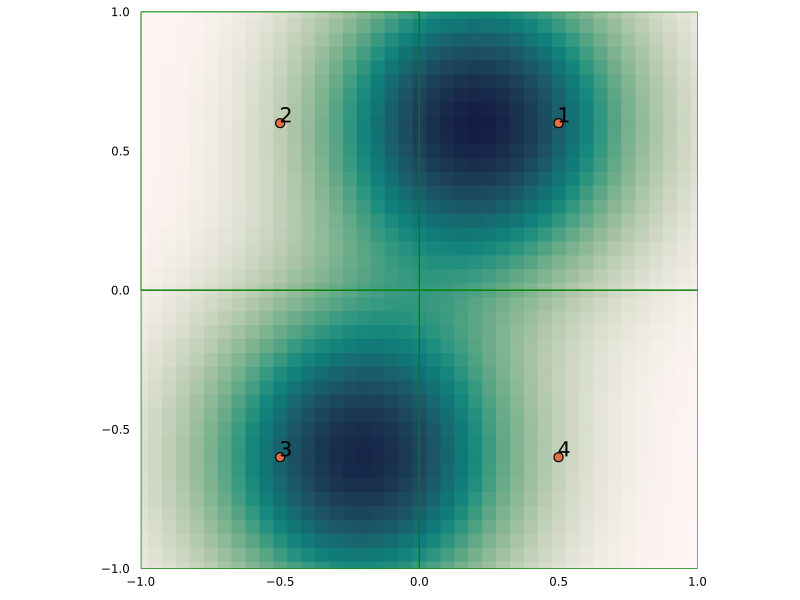

In [164]:
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

annotate!([(x1[i] + 0.02, x2[i] + 0.03, text(i, :black)) for i in 1:s]) # Add Station Number

plot!(tess, alpha=1, color=:green)

In [176]:
integrates = zeros(s)
for i=1:s
    v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
    g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
    integrates[i] = integrate_voronoi(g_out, A_X, P)
end
error_i = integrates - y
loss = 1/2*sum(error_i.^2);
minLoss = loss;
loss_vector = [loss]

1-element Vector{Float64}:
 2.369322130486267e-5

#### Bucle

In [177]:
for k = 1:15000 #integration_max_steps
    #nu = max(nu*nu_decay, nu_min)
    nu = 0.001
    
    # ========== STEP ========== 
    oldTheta = theta;
    dL = integrate(x, v_i, theta, error_i)
    theta = theta .- nu.*dL;
    w = calculate_w(v_i, y, theta[2], theta[3], A_X, P); # Calcular weights por minimos cuadrados
    theta = w, theta[2], theta[3] # Fixme: no me dejó sobreescribir, tuve que armar los 3 datos
    # ===========================

    # ========== Recalculate ========== 
    integrates = zeros(s)
    for i=1:s
        v = [[v_i[i][l,1], v_i[i][l,2]] for l=1:size(v_i[i])[1]];
        g_out = g.(v, w=theta[1], mu=theta[2], sigma2=theta[3])
        integrates[i] = integrate_voronoi(g_out, A_X, P)
    end
    error_i = integrates - y
    # =================================
    
    # ========== Comprobar descenso ==========
    oldLoss = loss
    loss = 1/2*sum(error_i.^2);
    push!(loss_vector, loss);
    #if loss > oldLoss 
    #    println("cortar por umbral en ", k, " iteraciones")
    #    k = integration_max_steps
    #    break
    #end
    # ========================================
end

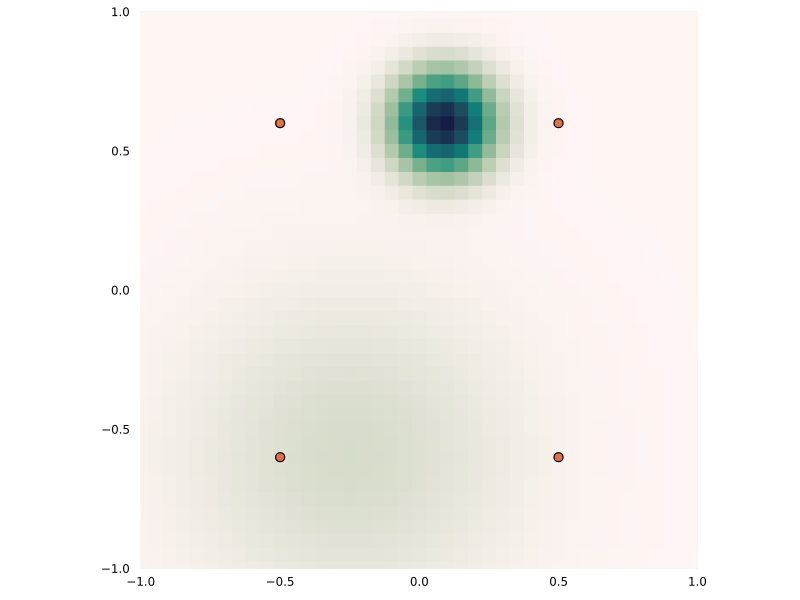

In [178]:
 z = rbf.(x_rbf, weights=theta[1],centers=theta[2],sigma2=theta[3]);
    
heatmap(x1_rbf, x2_rbf,z, aspect_ratio=:equal, c=:tempo, axis=:off, lims=(min(X1_min,X2_min),max(X1_max,X2_max)),colorbar=:none)
scatter!(x1, x2, legend=:none, colorbar=:none, markersize = 5)

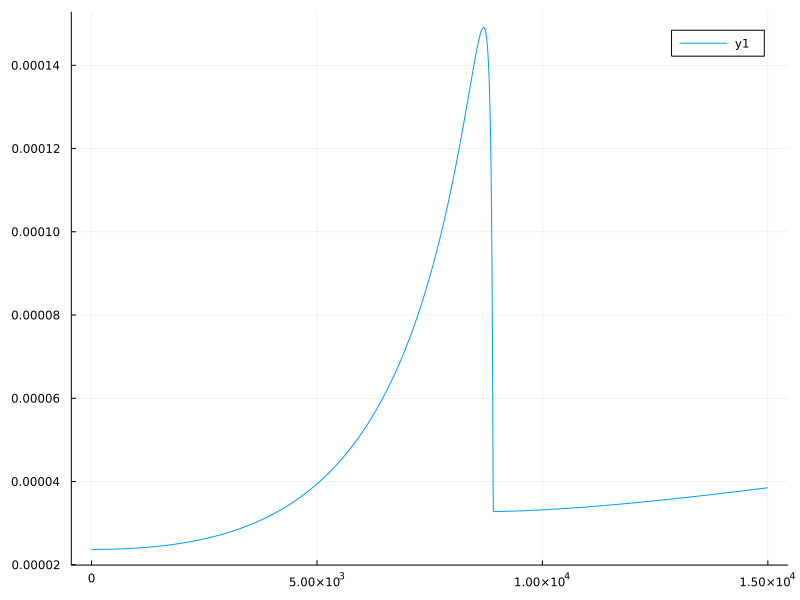

In [179]:
plot(loss_vector)

In [180]:
theta

([0.22330417074357956, 1.9619067113763426], [[-0.2505679692064187, -0.5924724543035237], [0.08872416267356928, 0.6002024876269815]], [0.31765113167649006, 0.028494326029814197])

In [181]:
w_ini, mu_ini, sigma2_ini

([0.15915494309189535, 0.15915494309189535], [[-0.5, -0.5], [0.5, 0.5]], [0.5, 0.5])

In [182]:
theta0

([0.23121710359926378, 0.23959484197207429], [[-0.2076325442485288, -0.5999999999999999], [0.20318701682900617, 0.6000000000000001]], [0.2866666666666667, 0.2866666666666668])

In [183]:
sum(y)

0.3541721607610413